
# Advanced Tensorflow Tutorial


# **RNN AND LSTM**




## RNN
Standard model of Recurrent Neural Network is very much similar to fully connected feed forward neural network. With the only difference that output of each layer becomes not only input to the next layer, but also to the layer itself – recurrent connection of outputs to inputs. Below is a block scheme of standard RNN, unrolled in time, so that it is seen that its output h(t) is calculated from the provided input x(t) and the history h(t-1) (output at time t-1).

RNNs may connect currently presented input with whatever was provided few steps before. However, as the gap between past and present inputs grows larger, RNNs struggle more and more to learn that connection.

![image.png](https://www.codeproject.com/KB/Articles/1272354/rnn_chain.png)

## Long Short-Term Memory (LSTM)
To address the issue of simple RNNs, the Long Short-Term Memory networks (LSTM) were introduced by Hochreiter and Schmidhuber in 1997, and then were popularized and refined by many other researchers. LSTM networks are a special kind of RNNs, capable of learning long-term dependencies. These networks are explicitly designed to avoid long-term dependency problem. Remembering information for long periods of time is practically default behaviour of LSTMs, not something they struggle to learn.

Unlike with simple RNNs, a single block of LSTM looks much more complex. It does considerably more computations inside and, in addition to its recurrent connection, has an internal state.

![image.png](https://www.codeproject.com/KB/Articles/1272354/lstm_chain.png)

 ## import libraries

In [50]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D , Dropout , Flatten , BatchNormalization,LSTM
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.metrics import confusion_matrix
import pandas as pd 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# **Dataset**



In [51]:
#  Read dataset

df=pd.read_csv("PRSA_Data_Aotizhongxin_20130301-20170228.csv")
df=df[['PM2.5','PM10','CO','TEMP','PRES','DEWP','RAIN','wd','WSPM']]
df.shape
df.head()

,PM2.5,PM10,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,4.0,300.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,8.0,8.0,300.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,7.0,7.0,300.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,6.0,6.0,300.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,3.0,3.0,300.0,-2.0,1025.2,-19.5,0.0,N,2.0


# **Preprocess**



In [52]:
from sklearn.exceptions import FitFailedWarning
# convert wind factor
mymap = {'N':0,'NNE':22.5,'NE':45,'ENE':67.5,'E':90,"ESE":112.5,"SE":135,"SSE":157.5,"S":180,'SSW':202.5,"SW":225,"WSW":247.5,"W":270,"WNW":292.5,"NW":315,"NNW":337.5}
df['wd']=df['wd'].map(mymap)
df.head()
check_nan=df.isnull().sum()
print(check_nan)
l=list(df.columns)
for i in l:
  df[i]=df[i].interpolate(method="linear")
check_nan=df.isnull().sum()
print(check_nan)
scaler=MinMaxScaler(feature_range=(0,1))
df=pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
df.head()

PM2.5     925
PM10      718
CO       1776
TEMP       20
PRES       20
DEWP       20
RAIN       20
wd         81
WSPM       14
dtype: int64
PM2.5    0
PM10     0
CO       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
dtype: int64


,PM2.5,PM10,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,0.001117,0.002037,0.020202,0.280977,0.661319,0.258621,0.0,1.000000,0.392857
1,0.005587,0.006110,0.020202,0.273997,0.664884,0.268025,0.0,0.000000,0.419643
2,0.004469,0.005092,0.020202,0.273997,0.670232,0.268025,0.0,1.000000,0.500000
3,0.003352,0.004073,0.020202,0.268761,0.688057,0.249216,0.0,0.933333,0.276786
4,0.000000,0.001018,0.020202,0.258290,0.700535,0.247649,0.0,0.000000,0.178571


<Axes: >

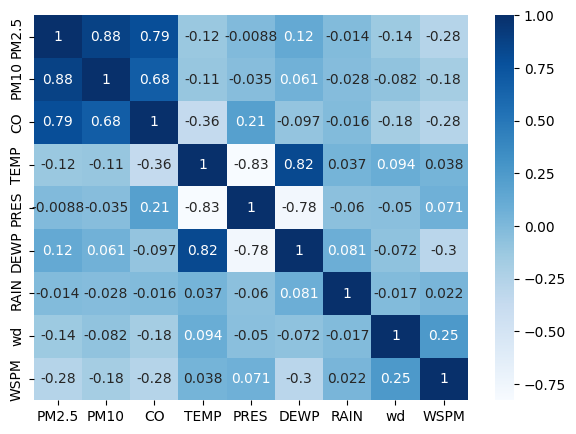

In [55]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(),annot=True,cmap=plt.cm.Blues)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

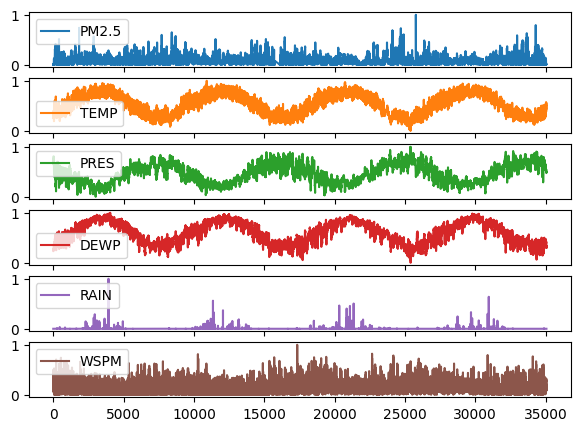

In [56]:
df[['PM2.5','TEMP','PRES','DEWP','RAIN','WSPM']].plot(subplots=True,figsize=(7,5))

**Creat Dataset**



In [57]:
##
def fun(data,lag):
  k=len(data)-lag
  x=[]
  y=[]
  for i in range(k):
    x.append(data[i:i+lag])
    y.append(data[i+lag,:3])
  x=np.array(x)
  y=np.array(y)
  return x,y
##

In [58]:
##
data=np.array(df)
train=data[:int(0.8*len(data))]
test=data[int(0.8*len(data)):]
lag=24
x_train,y_train=fun(train,lag)
x_test,y_test=fun(test,lag)
y_train.shape
##

(28027, 3)

# **Model**



In [61]:
##
callback=EarlyStopping(min_delta=1e-5,patience=5)
loss_fn=tf.keras.losses.MeanSquaredError()
model=Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(24,9)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(3,activation="relu"))
model.summary()
##

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 24, 100)           44000     
                                                                 
 dropout_8 (Dropout)         (None, 24, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 74,353
Trainable params: 74,353
Non-trainable params: 0
_________________________________________________________________


## training

In [63]:
##
model.compile(optimizer=Adam(learning_rate=0.001),loss=loss_fn)
history=model.fit(x_train,y_train,batch_size=128,epochs=10,callbacks=[callback],validation_data=(x_test,y_test))

##

Epoch 1/10
219/219 [==============================] - 12s 11ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 2/10
219/219 [==============================] - 2s 7ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 3/10
219/219 [==============================] - 2s 7ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/10
219/219 [==============================] - 2s 7ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 5/10
219/219 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0013 - val_loss: 9.9262e-04
Epoch 7/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 9.9135e-04
Epoch 8/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 9/10
219/219 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0012 - val_lo

# **Evaluation**



In [64]:
def model_plot(history):
    fig = plt.figure(figsize=(5,3))
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='test_Loss')
    plt.xlabel("epoch")
    plt.title('loss Function')
    plt.legend()

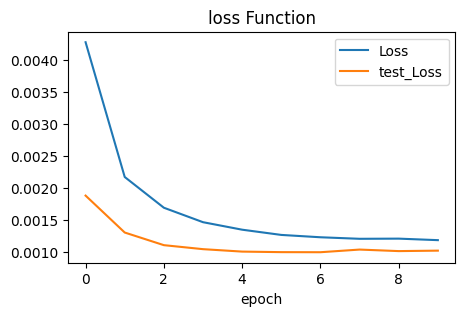

In [65]:
model_plot(history)

## prediction

219/219 [==============================] - 1s 3ms/step


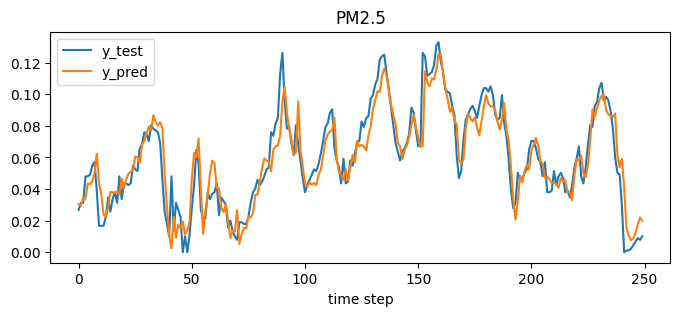

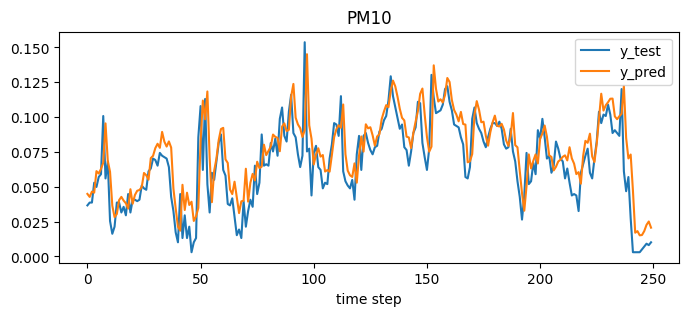

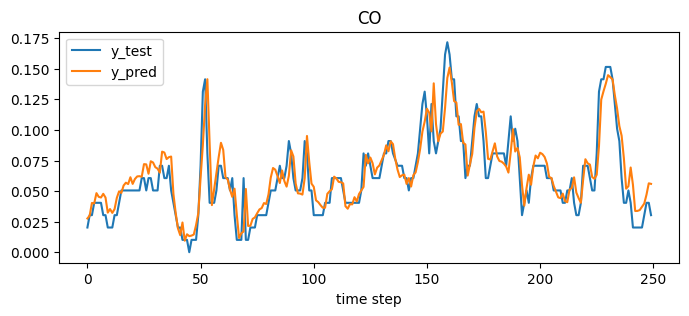

In [74]:
y_pred=model.predict(x_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test[:250,0], label='y_test')
plt.plot(y_pred[:250,0], label='y_pred')
plt.xlabel("time step")
plt.title('PM2.5')
plt.legend()
fig = plt.figure(figsize=(8,3))
plt.plot(y_test[:250,1], label='y_test')
plt.plot(y_pred[:250,1], label='y_pred')
plt.xlabel("time step")
plt.title('PM10')
plt.legend()
fig = plt.figure(figsize=(8,3))
plt.plot(y_test[:250,2], label='y_test')
plt.plot(y_pred[:250,2], label='y_pred')
plt.xlabel("time step")
plt.title('CO')
plt.legend()

In [75]:
MAE = mean_absolute_error(y_test,y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test,y_pred)
print('MAE : ',MAE)
print('RMSE : ',RMSE)
print('R2 : ',R2)

MAE :  0.016745953583278815
RMSE :  0.03187686491056537
R2 :  0.917715142745597
